In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import label_binarize
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import confusion_matrix

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

In [ ]:
df = pd.read_csv('data-final-project-raw.csv')

In [ ]:
#Preprocessing dan Analysis
df.head()

,nama_produk,harga,desc,terjual,total_rating,avg_rating,stock,os,kategori,store
0,Official Redmi A3 | Layar Muluz 90 Hz berukura...,Rp1.299.000,Desain Inovatif: Desain kamera deco yang memik...,Terjual 4 rb+,(1.956 rating),4.9,Stok: 274,Android OS,Handphone,Xiaomi Official Store
1,"vivo Y100 (8/256) - Magical Color Changing, 80...",Rp2.659.000,Y100 4G 8/256,Terjual 100+,(77 rating),4.9,Stok: 131,Android OS,Handphone,vivo Indonesia
2,TONER HP 87A BLACK ORIGINAL,Rp1.100.000,Toner Hp 87AHP LaserJet Black Toner Cartridge ...,No data available,No data available,No data available,Stok Total: 10000,Toner Printer,Printer,TUNAS-STATIONARY
3,HP Hot 40 Pro 16GB+512GB HD Handphone android ...,Rp880.000,✅ Produk memiliki masa garansi✅ Semua produk d...,Terjual 24,(17 rating),4.5,Stok: 497,Android OS,Handphone,hp reno11 pro
4,HP XIOMI REDMI NOTE 12 8/128GB // 8/256GB GARA...,Rp1.700.000,NETWORKTechnologyGSM / HSPA / LTEBODYDimension...,Terjual 5,(2 rating),5,Stok: Sisa 7,Android OS,Handphone,Gadget Store electronic


In [ ]:
#Generalisasi atribut kategori
kelompok_kategori = {
    'Elektronik': ['Handphone', 'Printer', 'Tablet', 'Laptop', 'Desktop & Mini PC',
                   'PC & Laptop Gaming', 'Game Console', 'CD Game', 'Audio', 'TV & Aksesoris',
                   'Lampu', 'Wearable Devices', 'Aksesoris Game Console', 'Monitor'],
    'Lainnya': ['Vitamin & Suplemen', 'Grooming', 'Eyebrow Kit', 'Persiapan Pernikahan', 'Document Organizer',
                'Perlengkapan Medis', 'Frame, Album & Roll Film', 'Aksesoris Muslim', 'Penyimpanan Makanan',
                'Bridal', 'Perlengkapan Kebersihan'],
    'Gadget & Elektronik Musik': ['Game Console', 'Gitar & Bass'],
    'Perawatan Pribadi': ['Masker Kecantikan', 'Perawatan Wajah', 'Perawatan Rambut', 'Styling Rambut Wanita'],
    'Peralatan Rumah Tangga': ['Peralatan Makan & Minum', 'Tempat Penyimpanan', 'Peralatan Dapur', 'Aksesoris Dapur',
                               'Kebersihan', 'Ruang Tamu & Keluarga', 'Kamar Tidur', 'Kamar Mandi'],
    'Olahraga & Outdoor': ['Sepak Bola & Futsal', 'Aksesoris Olahraga', 'Basket', 'Boxing', 'Golf', 'Hiking & Camping',
                            'Pakaian Olahraga Pria', 'Pakaian Olahraga Wanita'],
    'Pakaian & Fashion': ['Pakaian Dalam Wanita', 'Aksesoris Pria', 'Aksesoris Wanita', 'Aksesoris Sepatu Wanita',
                          'Pakaian Anak Perempuan', 'Jeans & Denim Wanita', 'Sepatu Wanita', 'Bawahan Wanita',
                          'Dress Muslim Wanita', 'Sepatu Pria', 'Atasan Wanita', 'Outerwear Pria', 'Outerwear Wanita',
                          'Atasan Pria', 'Jeans & Denim Pria', 'Topi Pria', 'Pakaian Adat Wanita', 'Tas Wanita',
                          'Tas Anak'],
    'Kendaraan & Aksesori': ['Helm Motor', 'Spare Part Mobil', 'Interior Mobil'],
    'Makanan & Minuman': ['Mie & Pasta', 'Sayur', 'Makanan Jadi', 'Penyimpanan Makanan', 'Bekal'],
    'Perhiasan & Aksesori': ['Perhiasan Wanita', 'Aksesoris Rambut', 'Model Kit'],
    'Mainan & Anak-Anak': ['Mainan Anak - Anak', 'Perlengkapan Mandi Bayi', 'Tas Anak'],
}

def kelompokan_kategori_fn(kategori_item):
    for kelompok, items in kelompok_kategori.items():
        if kategori_item in items:
            return kelompok
    return 'Lainnya'

df['kategori'] = df['kategori'].apply(kelompokan_kategori_fn)

In [ ]:
#Pergantian nama os menjadi sub_kategori
df = df.rename(columns={'os': 'sub_kategori'})

In [ ]:
#Pembersihan data raw
df['harga'] = df['harga'].replace({'Rp': '', '\\.': ''}, regex=True).astype(int)
df['store'] = df['store'].replace('No data available', 'Official Store')
df['avg_rating'] = df['avg_rating'].replace('No data available', np.nan)

def extract_number(stok):
    if isinstance(stok, str):
        result = re.findall(r'\d+', stok)
        return int(result[0]) if result else None
    return np.nan

df['stock'] = df['stock'].apply(extract_number)
df['stock'] = df['stock'].astype('Int64')

def extract_rating(rating):
    result = re.findall(r'\d+\.?\d*', rating)
    if result:
        number = result[0].replace('.', '')
        return int(number)
    return np.nan

df['total_rating'] = df['total_rating'].apply(extract_rating)

def extract_terjual(terjual):
    result = re.findall(r'\d+', terjual)
    if result:
        number = int(result[0])
        if 'rb' in terjual:
            number *= 1000
        return number
    return np.nan

df['terjual'] = df['terjual'].apply(extract_terjual)

In [ ]:
#Melabeli kategori dan sub_kategori menggunakan numerikal
label_encoder = LabelEncoder()
df['kategori_encoding'] = label_encoder.fit_transform(df['kategori']) + 1
df['sub_kategori_encoding'] = label_encoder.fit_transform(df['sub_kategori']) + 1

In [ ]:
#Mengecek data NaN atau Null
print(df.isnull().sum())

nama_produk                0
harga                      0
desc                       0
terjual                  538
total_rating             551
avg_rating               551
stock                      5
sub_kategori               0
kategori                   0
store                      0
kategori_encoding          0
sub_kategori_encoding      0
dtype: int64


In [ ]:
#Mengecek data deskriptif dari dataset
df.describe()

,harga,terjual,total_rating,stock,kategori_encoding,sub_kategori_encoding
count,1.172000e+03,634.000000,621.000000,1167.0,1172.000000,1172.000000
mean,1.704042e+06,840.011041,279.872786,999.87575,4.399317,71.213311
std,4.378985e+06,4711.732445,812.530765,8095.918749,3.540074,46.954333
min,1.000000e+02,1.000000,1.000000,1.0,1.000000,1.000000
25%,8.500000e+04,24.250000,11.000000,6.0,1.000000,24.000000
50%,2.399500e+05,100.000000,45.000000,23.0,4.000000,76.500000
75%,1.499900e+06,500.000000,169.000000,100.0,8.000000,113.000000
max,1.000000e+08,100000.000000,7194.000000,100000.0,11.000000,159.000000


In [ ]:
#Pengisian data Nan
def fillDataNaN(row):
    if pd.isna(row):
        if np.random.rand() < 0.7:
            available_values = np.arange(1, 999)
        else:
            available_values = np.arange(1000, 10000)
        return np.random.choice(available_values)
    return row

df['terjual'] = df['terjual'].apply(fillDataNaN)

In [ ]:
#Pengisian data Nan
def fillDataNaN(row):
    if pd.isna(row):
        available_values = np.arange(2.5, 3.9, 0.5)
        return np.random.choice(available_values)
    return row

df['avg_rating'] = pd.to_numeric(df['avg_rating'], errors='coerce')
df['avg_rating'] = df['avg_rating'].apply(fillDataNaN)

In [ ]:
#Pengisian data Nan
def fillDataNaN(row):
    if pd.isna(row):
        if np.random.rand() < 0.2:
            available_values = np.arange(1000, 7194)
        else:
            available_values = np.arange(1, 999)
        return np.random.choice(available_values)
    return row

df['total_rating'] = df['total_rating'].apply(fillDataNaN)

In [ ]:
#Pengisian data Nan
def fillDataNaN(row):
    if pd.isna(row):
        available_values = np.arange(1000, 5000)
        return np.random.choice(available_values)
    return row

df['stock'] = df['stock'].apply(fillDataNaN)

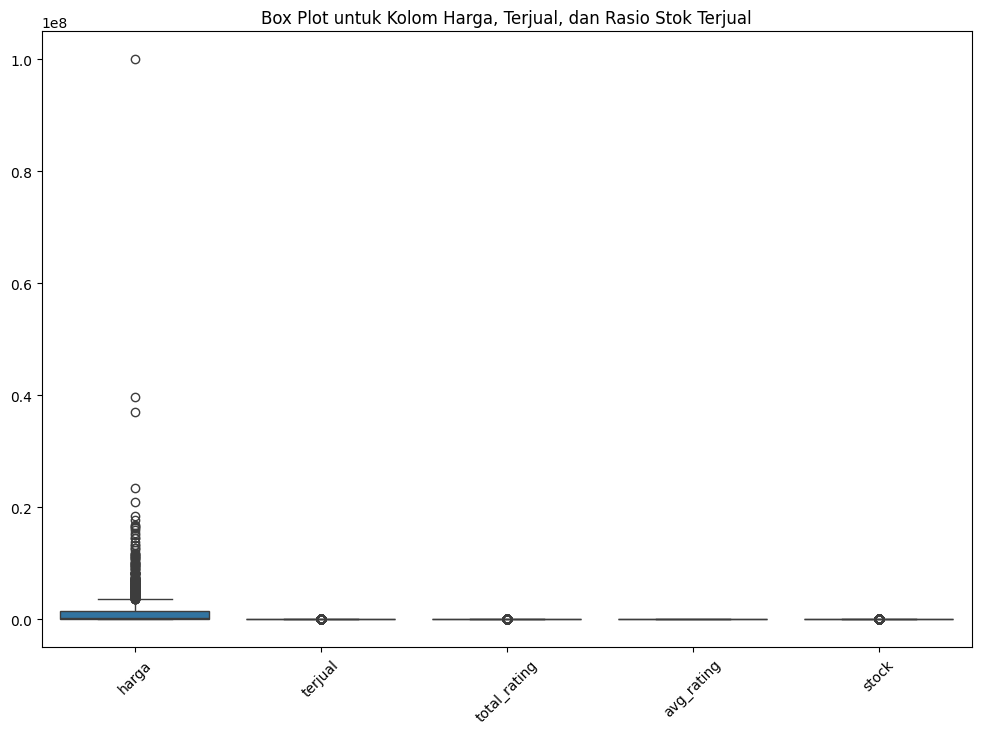

In [ ]:
#Pengecekan Outlier
numerical_columns = ['harga', 'terjual', 'total_rating', 'avg_rating', 'stock']
plt.figure(figsize=(12, 8))

sns.boxplot(data=df[numerical_columns])
plt.title('Box Plot untuk Kolom Harga, Terjual, dan Rasio Stok Terjual')
plt.xticks(rotation=45)
plt.show()

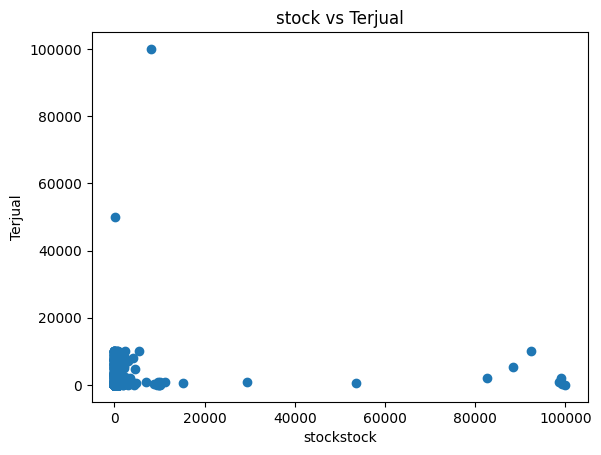

In [ ]:
#Pengecekan Outlier
plt.scatter(df['stock'], df['terjual'])
plt.xlabel('stockstock')
plt.ylabel('Terjual')
plt.title('stock vs Terjual')
plt.show()

In [ ]:
#Menghapusan Outlier
columns_to_check = ['terjual', 'total_rating', 'stock']

for column in columns_to_check:
    Q1 = df[column].quantile(0.15)
    Q3 = df[column].quantile(0.85)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

df.describe()

,harga,terjual,total_rating,avg_rating,stock,kategori_encoding,sub_kategori_encoding
count,9.340000e+02,934.000000,934.000000,934.000000,934.000000,934.000000,934.000000
mean,1.695225e+06,810.138116,323.320128,4.168201,92.610278,4.156317,70.612420
std,4.428248e+06,1506.946364,402.204042,0.966184,182.358639,3.459020,46.966975
min,1.100000e+03,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000
25%,9.291750e+04,50.000000,24.000000,3.125000,5.000000,1.000000,24.000000
50%,2.725000e+05,250.000000,137.500000,4.900000,19.000000,4.000000,76.000000
75%,1.669500e+06,750.000000,532.500000,5.000000,86.750000,8.000000,113.000000
max,1.000000e+08,7374.000000,2257.000000,5.000000,957.000000,11.000000,159.000000


In [ ]:
#Penyimpanan cleaned dataset
df.to_csv('data-final-project-cleaned.csv', index=False)
df = pd.read_csv('data-final-project-cleaned.csv')

In [ ]:
#Penambahan Atribut
df['harga_per_rating'] = df['harga'] / (df['total_rating'] + 1)
df['harga_terjual'] = df['harga'] * df['terjual']
df['skor_popularitas'] = (df['avg_rating'] * 0.4) + (df['terjual'] * 0.4) + (df['total_rating'] * 0.2)
df['avg_harga_per_kategori'] = df.groupby('kategori')['harga'].transform('mean')
df['stok_terjual_ratio'] = df['stock'] / (df['terjual'] + 1)
df['stok_ideal'] = df['stok_terjual_ratio'] * df['stock']
df['rasio_penjualan_stok'] = df['terjual'] / (df['stock'] + 1)
df['stok_ideal'] = np.ceil(df['stok_ideal'])
df['skor_popularitas'] = df['skor_popularitas'].round()

In [ ]:
#Penambahan Atribut Class
def harga_kategori(row):
    if row["harga"] > 800000:
        return "Tinggi"
    elif 200000 <= row["harga"] <= 800000:
        return "Sedang"
    else:
        return "Rendah"

df["harga_kategori"] = df.apply(harga_kategori, axis=1)
df['harga_kategori_encoding'] = df['harga_kategori'].map({'Tinggi': 2, 'Sedang': 1, 'Rendah': 0})
df["harga_kategori"].value_counts()

df['restock'] = df.apply(
    lambda x: 'Restock' if x['stok_ideal'] / x['stock'] < 1
    else ('Tidak Restock' if x['stok_ideal'] / x['stock'] == 1
    else 'Stok Berlebih'), axis=1)

df['restock_encoding'] = df['restock'].map({'Restock': 2,'Tidak Restock' : 1, 'Stok Berlebih': 0})
df['restock'].value_counts()

df['popularitas'] = df['skor_popularitas'].apply(
    lambda x: 'Sangat Populer' if x > 4 else ('Populer' if x > 3 else 'Tidak Populer')
)
df['popularitas_encoding'] = df['popularitas'].map({'Sangat Populer': 2, 'Populer': 1, 'Tidak Populer': 0})
df['popularitas'].value_counts()

,count
popularitas,
Sangat Populer,890
Tidak Populer,23
Populer,21


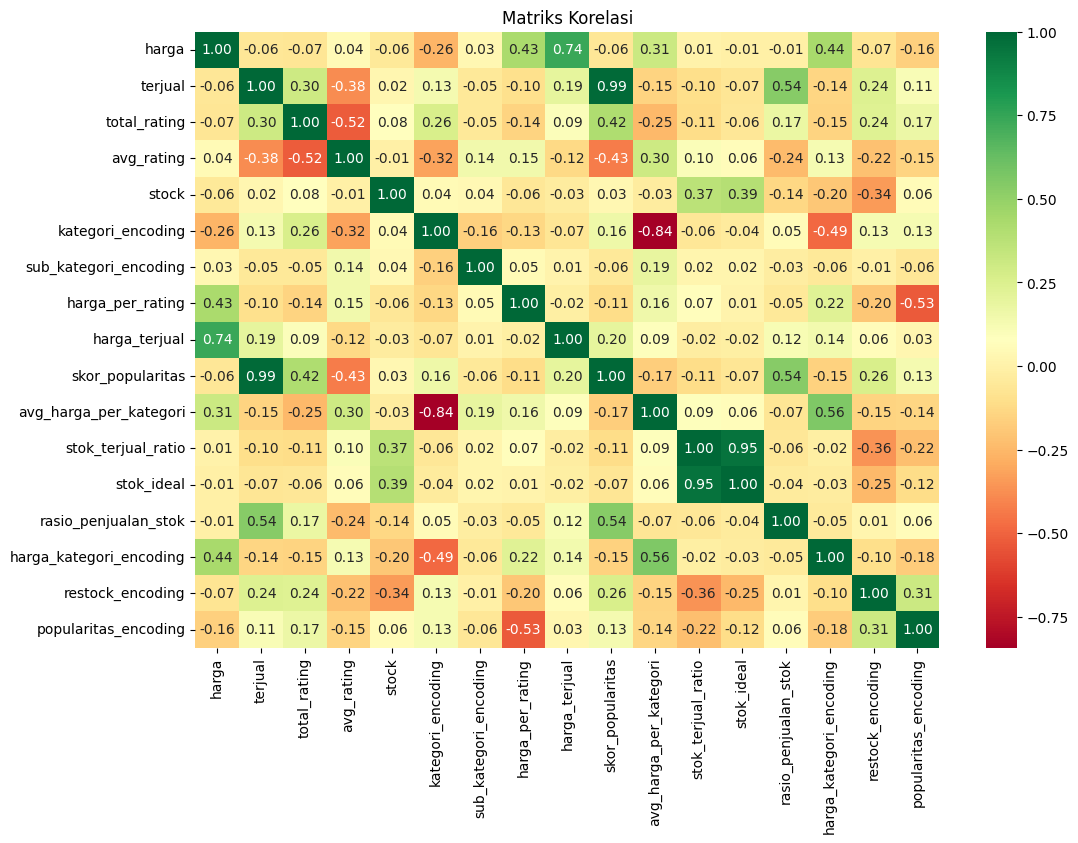

In [ ]:
#Korelasi antar atribut
df_numeric = df.select_dtypes(include=['number'])
correlation_matrix = df_numeric.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='RdYlGn')
plt.title('Matriks Korelasi')
plt.show()

In [ ]:
#Simpan CSV Atribut Extend
df.to_csv('data-final-project-cleaned-atribut-extend.csv', index=False)

In [ ]:
df = pd.read_csv('data-final-project-cleaned-atribut-extend.csv')

In [ ]:
#Skenario Perbandingan Model

dfDPM = df.drop(columns=['nama_produk', 'desc', 'store', 'kategori', 'sub_kategori', 'harga_kategori'], errors='ignore')
X = dfDPM[['avg_harga_per_kategori', 'harga_per_rating', 'harga_terjual']]
y = dfDPM['harga_kategori_encoding']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

rf_modelPrice = RandomForestClassifier(bootstrap=True, criterion='gini', max_depth=4, max_features='sqrt', min_samples_split=5, min_samples_leaf=5, n_estimators=300)
rf_modelPrice.fit(X_train, y_train)

lr_modelPrice = LogisticRegression(C=1, max_iter=1000, penalty='l2', solver='lbfgs')
lr_modelPrice.fit(X_train, y_train)

svm_modelPrice = SVC()
svm_modelPrice.fit(X_train, y_train)

knn_modelPrice = KNeighborsClassifier(n_neighbors=15, p=2, weights='uniform')
knn_modelPrice.fit(X_train, y_train)

xgb_modelPrice = XGBClassifier(objective='multi:softprob', learning_rate=0.05, max_depth=3, n_estimators=100, subsample=0.8, colsample_bytree=0.8)
xgb_modelPrice.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [ ]:
#Clasification Report Testing and Training Evaluation
models = {'Random Forest': rf_modelPrice, 'Logistic Regression': lr_modelPrice, 'SVM': svm_modelPrice, 'KNN': knn_modelPrice, 'XGBoost': xgb_modelPrice}

for model_name, model in models.items():
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    print(f"{model_name} - Training Data Evaluation:")
    print(classification_report(y_train, y_train_pred, zero_division=1))

    print(f"{model_name} - Testing Data Evaluation:")
    print(classification_report(y_test, y_test_pred, zero_division=1))

Random Forest - Training Data Evaluation:
              precision    recall  f1-score   support

           0       0.83      0.97      0.89       275
           1       0.78      0.48      0.60       145
           2       0.91      0.95      0.93       233

    accuracy                           0.85       653
   macro avg       0.84      0.80      0.81       653
weighted avg       0.85      0.85      0.84       653

Random Forest - Testing Data Evaluation:
              precision    recall  f1-score   support

           0       0.77      0.93      0.84       127
           1       0.62      0.36      0.46        69
           2       0.86      0.88      0.87        85

    accuracy                           0.78       281
   macro avg       0.75      0.72      0.72       281
weighted avg       0.76      0.78      0.76       281

Logistic Regression - Training Data Evaluation:
              precision    recall  f1-score   support

           0       0.74      0.68      0.71       27

In [ ]:
#Cross Validation Evaluation
for model_name, model in models.items():
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    print(f'{model_name} - Cross-validation scores: {cv_scores}')
    print(f'{model_name} - Mean CV score: {np.mean(cv_scores)}\n')

Random Forest - Cross-validation scores: [0.83206107 0.81679389 0.83206107 0.78461538 0.76923077]
Random Forest - Mean CV score: 0.8069524368761011

Logistic Regression - Cross-validation scores: [0.66412214 0.59541985 0.58778626 0.6        0.64615385]
Logistic Regression - Mean CV score: 0.6186964180857311

SVM - Cross-validation scores: [0.46564885 0.52671756 0.53435115 0.51538462 0.47692308]
SVM - Mean CV score: 0.5038050499119201

KNN - Cross-validation scores: [0.57251908 0.59541985 0.55725191 0.55384615 0.56923077]
KNN - Mean CV score: 0.5696535525543158

XGBoost - Cross-validation scores: [0.87022901 0.83206107 0.88549618 0.81538462 0.82307692]
XGBoost - Mean CV score: 0.8452495596007046



In [ ]:
#Confusion Matrix Evaluation
predictions = pd.DataFrame({
    'Actual': y_test,
    'Random Forest': rf_modelPrice.predict(X_test),
    'Logistic Regression': lr_modelPrice.predict(X_test),
    'SVM': svm_modelPrice.predict(X_test),
    'KNN': knn_modelPrice.predict(X_test),
    'XGBoost': xgb_modelPrice.predict(X_test)
})

for model_name in models.keys():
    print(f"Crosstab for {model_name}:")
    crosstab = pd.crosstab(predictions['Actual'], predictions[model_name], margins=True)
    print(crosstab)
    print("\n")

Crosstab for Random Forest:
Random Forest    0   1   2  All
Actual                         
0              118   7   2  127
1               34  25  10   69
2                2   8  75   85
All            154  40  87  281


Crosstab for Logistic Regression:
Logistic Regression    0    2  All
Actual                            
0                     85   42  127
1                     25   44   69
2                      7   78   85
All                  117  164  281


Crosstab for SVM:
SVM       0   2  All
Actual              
0       125   2  127
1        64   5   69
2        57  28   85
All     246  35  281


Crosstab for KNN:
KNN       0   1   2  All
Actual                  
0        94  13  20  127
1        41   8  20   69
2        18   9  58   85
All     153  30  98  281


Crosstab for XGBoost:
XGBoost    0   1   2  All
Actual                   
0        114  11   2  127
1         19  40  10   69
2          2   5  78   85
All      135  56  90  281




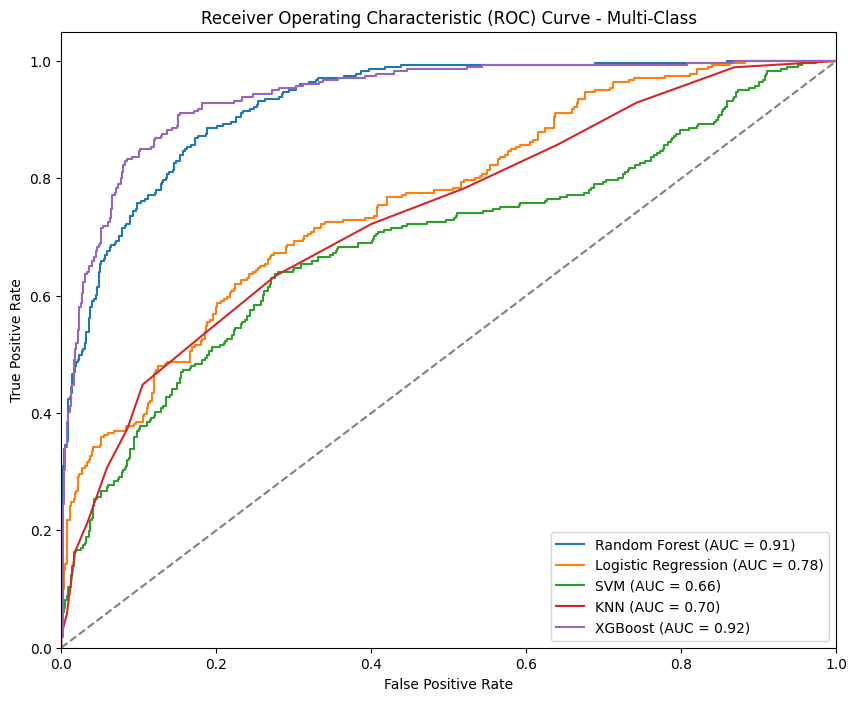

In [ ]:
#ROC AUC Evaluation
y_train_bin = label_binarize(y_train, classes=[0, 1, 2])
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])

plt.figure(figsize=(10, 8))

for model_name, model in models.items():
    model.fit(X_train, y_train)

    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)
    else:
        y_prob = model.decision_function(X_test)

    fpr, tpr, _ = roc_curve(y_test_bin.ravel(), y_prob.ravel())
    auc_score = roc_auc_score(y_test_bin, y_prob, multi_class='ovr')

    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc_score:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Multi-Class')
plt.legend(loc='lower right')
plt.show()

In [ ]:
#Skenario Perbandingan Model

dfDPM = df.drop(columns=['nama_produk', 'desc', 'store', 'kategori', 'sub_kategori', 'harga_kategori', 'restock', 'popularitas'], errors='ignore')
X = dfDPM[['stok_ideal','stok_terjual_ratio', 'rasio_penjualan_stok']]
y = dfDPM['restock_encoding']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_resampleds, y_train_resampleds = smote.fit_resample(X_train, y_train)

undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train_resampleds, y_train_resampleds)

rf_modelStock = RandomForestClassifier(bootstrap=True, criterion='gini', max_depth=4, max_features='sqrt', min_samples_split=5, min_samples_leaf=5, n_estimators=300)
rf_modelStock.fit(X_train_resampled, y_train_resampled)

lr_modelStock = LogisticRegression(C=1, max_iter=1000, penalty='l2', solver='lbfgs')
lr_modelStock.fit(X_train_resampled, y_train_resampled)

svm_modelStock = SVC()
svm_modelStock.fit(X_train_resampled, y_train_resampled)

knn_modelStock = KNeighborsClassifier(n_neighbors=15, p=2, weights='uniform')
knn_modelStock.fit(X_train_resampled, y_train_resampled)

xgb_modelStock = XGBClassifier(objective='multi:softprob', learning_rate=0.05, max_depth=3, n_estimators=100, subsample=0.8, colsample_bytree=0.8)
xgb_modelStock.fit(X_train_resampled, y_train_resampled)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [ ]:
#Clasification Report Testing and Training Evaluation
models = {'Random Forest': rf_modelStock, 'Logistic Regression': lr_modelStock, 'SVM': svm_modelStock, 'KNN': knn_modelStock, 'XGBoost': xgb_modelStock}

for model_name, model in models.items():
    y_train_pred = model.predict(X_train_resampled)
    y_test_pred = model.predict(X_test)

    print(f"{model_name} - Training Data Evaluation:")
    print(classification_report(y_train_resampled, y_train_pred, zero_division=1))

    print(f"{model_name} - Testing Data Evaluation:")
    print(classification_report(y_test, y_test_pred, zero_division=1))

Random Forest - Training Data Evaluation:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       453
           1       0.90      0.79      0.84       453
           2       0.82      0.91      0.86       453

    accuracy                           0.90      1359
   macro avg       0.90      0.90      0.90      1359
weighted avg       0.90      0.90      0.90      1359

Random Forest - Testing Data Evaluation:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        43
           1       0.57      0.71      0.63        35
           2       0.95      0.91      0.93       203

    accuracy                           0.90       281
   macro avg       0.84      0.87      0.85       281
weighted avg       0.91      0.90      0.90       281

Logistic Regression - Training Data Evaluation:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       45

In [ ]:
#Cross Validation Evaluation
for model_name, model in models.items():
    cv_scores = cross_val_score(model, X_train_resampled, y_train_resampled, cv=5, scoring='accuracy')
    print(f'{model_name} - Cross-validation scores: {cv_scores}')
    print(f'{model_name} - Mean CV score: {np.mean(cv_scores)}\n')

Random Forest - Cross-validation scores: [0.84926471 0.84558824 0.875      0.88235294 0.83394834]
Random Forest - Mean CV score: 0.8572308443672672

Logistic Regression - Cross-validation scores: [0.78308824 0.78308824 0.82352941 0.79779412 0.80811808]
Logistic Regression - Mean CV score: 0.7991236162361623

SVM - Cross-validation scores: [0.51470588 0.54044118 0.51102941 0.52573529 0.52767528]
SVM - Mean CV score: 0.52391740829173

KNN - Cross-validation scores: [0.76838235 0.77573529 0.78308824 0.79411765 0.79704797]
KNN - Mean CV score: 0.7836742999782939

XGBoost - Cross-validation scores: [0.92647059 0.91544118 0.92647059 0.94485294 0.94095941]
XGBoost - Mean CV score: 0.9308389407423487



In [ ]:
#Confusion Matrix Evaluation
predictions = pd.DataFrame({
    'Actual': y_test,
    'Random Forest': rf_modelStock.predict(X_test),
    'Logistic Regression': lr_modelStock.predict(X_test),
    'SVM': svm_modelStock.predict(X_test),
    'KNN': knn_modelStock.predict(X_test),
    'XGBoost': xgb_modelStock.predict(X_test)
})

for model_name in models.keys():
    print(f"Crosstab for {model_name}:")
    crosstab = pd.crosstab(predictions['Actual'], predictions[model_name], margins=True)
    print(crosstab)
    print("\n")

Crosstab for Random Forest:
Random Forest   0   1    2  All
Actual                         
0              43   0    0   43
1               0  25   10   35
2               0  19  184  203
All            43  44  194  281


Crosstab for Logistic Regression:
Logistic Regression   0   1    2  All
Actual                               
0                    38   3    2   43
1                     0  13   22   35
2                     1  35  167  203
All                  39  51  191  281


Crosstab for SVM:
SVM      0  1    2  All
Actual                 
0       21  0   22   43
1        0  2   33   35
2        3  5  195  203
All     24  7  250  281


Crosstab for KNN:
KNN      0   1    2  All
Actual                  
0       39   2    2   43
1        1  23   11   35
2       16  51  136  203
All     56  76  149  281


Crosstab for XGBoost:
XGBoost   0   1    2  All
Actual                   
0        41   2    0   43
1         0  31    4   35
2         0  27  176  203
All      41  60  180  281




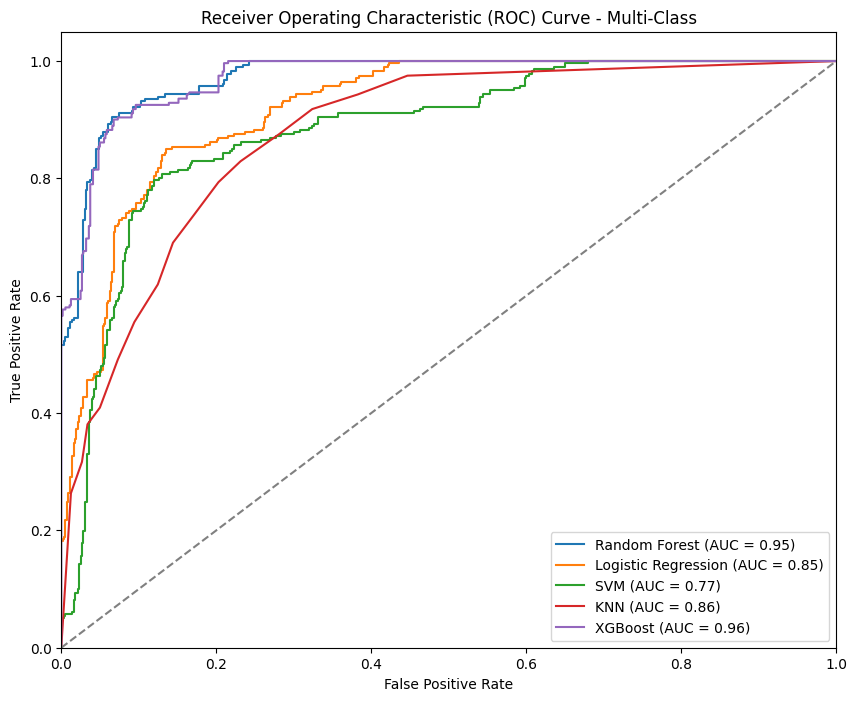

In [ ]:
#ROC AUC Evaluation
y_train_bin = label_binarize(y_train_resampled, classes=[0, 1, 2])
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])

plt.figure(figsize=(10, 8))

for model_name, model in models.items():
    model.fit(X_train_resampled, y_train_resampled)

    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)
    else:
        y_prob = model.decision_function(X_test)

    fpr, tpr, _ = roc_curve(y_test_bin.ravel(), y_prob.ravel())
    auc_score = roc_auc_score(y_test_bin, y_prob, multi_class='ovr')

    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc_score:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Multi-Class')
plt.legend(loc='lower right')
plt.show()

In [ ]:
#Skenario Perbandingan Model

dfDPM = df.drop(columns=['nama_produk', 'desc', 'store', 'kategori', 'sub_kategori', 'harga_kategori', 'restock', 'popularitas'], errors='ignore')
X = dfDPM[['harga_per_rating', 'rasio_penjualan_stok', 'total_rating']]
#X = dfDPM.drop(columns=['popularitas_encoding'])
y = dfDPM['popularitas_encoding']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_resampleds, y_train_resampleds = smote.fit_resample(X_train, y_train)

undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train_resampleds, y_train_resampleds)

rf_modelPopu = RandomForestClassifier(bootstrap=True, criterion='gini', max_depth=4, max_features='sqrt', min_samples_split=5, min_samples_leaf=5, n_estimators=300)
rf_modelPopu.fit(X_train_resampled, y_train_resampled)

lr_modelPopu = LogisticRegression(C=1, max_iter=1000, penalty='l2', solver='lbfgs')
lr_modelPopu.fit(X_train_resampled, y_train_resampled)

svm_modelPopu = SVC()
svm_modelPopu.fit(X_train_resampled, y_train_resampled)

knn_modelPopu = KNeighborsClassifier(n_neighbors=15, p=2, weights='uniform')
knn_modelPopu.fit(X_train_resampled, y_train_resampled)

xgb_modelPopu = XGBClassifier(objective='multi:softprob', learning_rate=0.05, max_depth=3, n_estimators=100, subsample=0.8, colsample_bytree=0.8)
xgb_modelPopu.fit(X_train_resampled, y_train_resampled)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [ ]:
#Clasification Report Testing and Training Evaluation
models = {'Random Forest': rf_modelPopu, 'Logistic Regression': lr_modelPopu, 'SVM': svm_modelPopu, 'KNN': knn_modelPopu, 'XGBoost': xgb_modelPopu}

for model_name, model in models.items():
    y_train_pred = model.predict(X_train_resampled)
    y_test_pred = model.predict(X_test)

    print(f"{model_name} - Training Data Evaluation:")
    print(classification_report(y_train_resampled, y_train_pred, zero_division=1))

    print(f"{model_name} - Testing Data Evaluation:")
    print(classification_report(y_test, y_test_pred, zero_division=1))

Random Forest - Training Data Evaluation:
              precision    recall  f1-score   support

           0       0.93      0.99      0.96       618
           1       0.98      0.93      0.95       618
           2       1.00      0.98      0.99       618

    accuracy                           0.97      1854
   macro avg       0.97      0.97      0.97      1854
weighted avg       0.97      0.97      0.97      1854

Random Forest - Testing Data Evaluation:
              precision    recall  f1-score   support

           0       0.50      1.00      0.67         4
           1       0.00      0.00      0.00         5
           2       0.99      0.98      0.99       272

    accuracy                           0.96       281
   macro avg       0.50      0.66      0.55       281
weighted avg       0.97      0.96      0.96       281

Logistic Regression - Training Data Evaluation:
              precision    recall  f1-score   support

           0       0.87      0.88      0.88       61

In [ ]:
#Cross Validation Evaluation
for model_name, model in models.items():
    cv_scores = cross_val_score(model, X_train_resampled, y_train_resampled, cv=5, scoring='accuracy')
    print(f'{model_name} - Cross-validation scores: {cv_scores}')
    print(f'{model_name} - Mean CV score: {np.mean(cv_scores)}\n')

Random Forest - Cross-validation scores: [0.9541779  0.98113208 0.97843666 0.94878706 0.95945946]
Random Forest - Mean CV score: 0.9643986304363663

Logistic Regression - Cross-validation scores: [0.91913747 0.94070081 0.94339623 0.93530997 0.90540541]
Logistic Regression - Mean CV score: 0.9287899759597872

SVM - Cross-validation scores: [0.64690027 0.65498652 0.64959569 0.67654987 0.67297297]
SVM - Mean CV score: 0.66020106359729

KNN - Cross-validation scores: [0.7574124  0.78975741 0.77897574 0.75471698 0.71621622]
KNN - Mean CV score: 0.7594157499817877

XGBoost - Cross-validation scores: [0.98113208 0.98382749 0.98921833 0.97843666 0.96486486]
XGBoost - Mean CV score: 0.979495884024186



In [ ]:
#Confusion Matrix Evaluation
predictions = pd.DataFrame({
    'Actual': y_test,
    'Random Forest': rf_modelPopu.predict(X_test),
    'Logistic Regression': lr_modelPopu.predict(X_test),
    'SVM': svm_modelPopu.predict(X_test),
    'KNN': knn_modelPopu.predict(X_test),
    'XGBoost': xgb_modelPopu.predict(X_test)
})

for model_name in models.keys():
    print(f"Crosstab for {model_name}:")
    crosstab = pd.crosstab(predictions['Actual'], predictions[model_name], margins=True)
    print(crosstab)
    print("\n")

Crosstab for Random Forest:
Random Forest  0  1    2  All
Actual                       
0              4  0    0    4
1              3  0    2    5
2              1  5  266  272
All            8  5  268  281


Crosstab for Logistic Regression:
Logistic Regression  0   1    2  All
Actual                              
0                    4   0    0    4
1                    3   2    0    5
2                    1   8  263  272
All                  8  10  263  281


Crosstab for SVM:
SVM     0   1    2  All
Actual                 
0       2   2    0    4
1       2   1    2    5
2       0  13  259  272
All     4  16  261  281


Crosstab for KNN:
KNN      0   1    2  All
Actual                  
0        3   1    0    4
1        2   1    2    5
2        8  37  227  272
All     13  39  229  281


Crosstab for XGBoost:
XGBoost  0  1    2  All
Actual                 
0        3  1    0    4
1        2  2    1    5
2        0  5  267  272
All      5  8  268  281




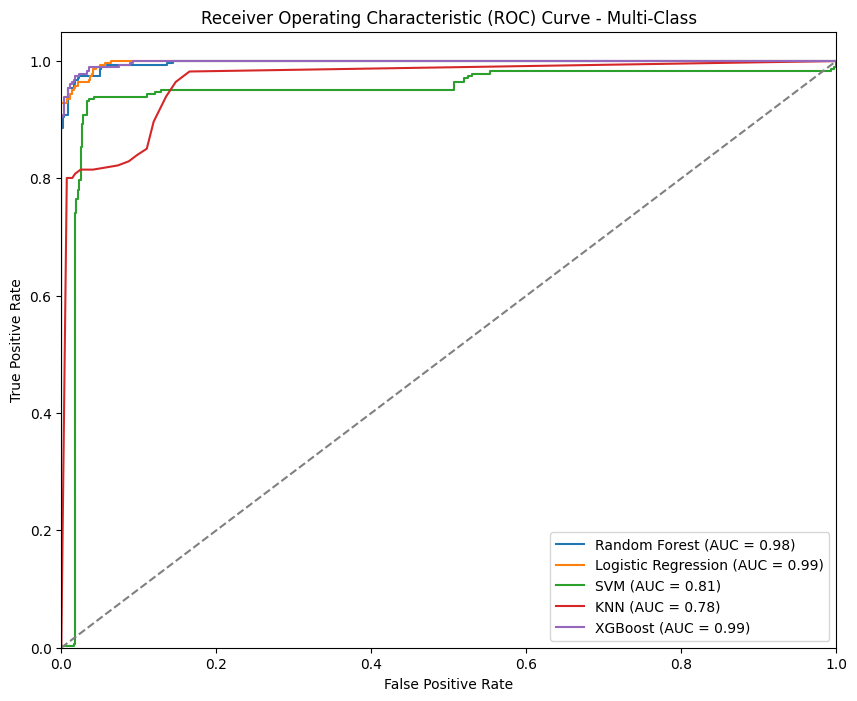

In [ ]:
#ROC AUC Evaluation
y_train_bin = label_binarize(y_train_resampled, classes=[0, 1, 2])
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])

plt.figure(figsize=(10, 8))

for model_name, model in models.items():
    model.fit(X_train_resampled, y_train_resampled)

    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)
    else:
        y_prob = model.decision_function(X_test)

    fpr, tpr, _ = roc_curve(y_test_bin.ravel(), y_prob.ravel())
    auc_score = roc_auc_score(y_test_bin, y_prob, multi_class='ovr')

    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc_score:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Multi-Class')
plt.legend(loc='lower right')
plt.show()

Rekomendasi Fitur Berdasarkan Pentingnya:
                    Feature  Importance
9          skor_popularitas    0.454607
1                   terjual    0.245054
2              total_rating    0.105924
7          harga_per_rating    0.054226
13     rasio_penjualan_stok    0.032314
11       stok_terjual_ratio    0.023275
8             harga_terjual    0.017554
0                     harga    0.013475
12               stok_ideal    0.011334
4                     stock    0.010760
3                avg_rating    0.008837
15         restock_encoding    0.006458
6     sub_kategori_encoding    0.004727
5         kategori_encoding    0.004548
10   avg_harga_per_kategori    0.003495
14  harga_kategori_encoding    0.003412


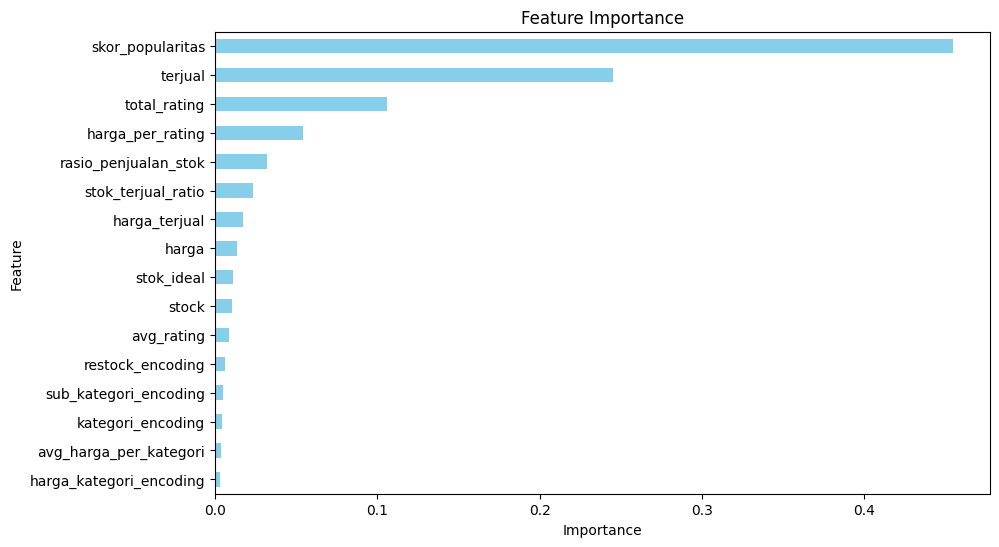

In [ ]:
X = dfDPM.drop(columns=['popularitas_encoding'])
y = dfDPM['popularitas_encoding']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

feature_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("Rekomendasi Fitur Berdasarkan Pentingnya:")
print(feature_df)

feature_df.plot.barh(x='Feature', y='Importance', color='skyblue', figsize=(10, 6), legend=False)
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.show()

In [ ]:
correlation_matrix = dfDPM.corr()

print(correlation_matrix['popularitas_encoding'].sort_values(ascending=False))

popularitas_encoding       1.000000
restock_encoding           0.313534
total_rating               0.168737
skor_popularitas           0.129247
kategori_encoding          0.126000
terjual                    0.113041
rasio_penjualan_stok       0.061720
stock                      0.055384
harga_terjual              0.026653
sub_kategori_encoding     -0.061048
stok_ideal                -0.115355
avg_harga_per_kategori    -0.139522
avg_rating                -0.151252
harga                     -0.164247
harga_kategori_encoding   -0.176582
stok_terjual_ratio        -0.223864
harga_per_rating          -0.526253
Name: popularitas_encoding, dtype: float64


In [ ]:
#Model digunakan dipilih
rf_modelPrice #Menentukan harga dinamis
rf_modelStock #Menentukan stock ideal
xgb_modelPopu #Menentukan popularitas produk

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [ ]:
#Eksport Model
import pickle

pickle_out = open("rf_modelPrice.sav", "wb")
pickle.dump(rf_modelPrice, pickle_out)
pickle_out.close()

In [ ]:
#Eksport Model
import pickle

pickle_out = open("rf_modelStock.sav", "wb")
pickle.dump(rf_modelStock, pickle_out)
pickle_out.close()

In [ ]:
#Eksport Model
import pickle

pickle_out = open("rf_modelPopu.sav", "wb")
pickle.dump(rf_modelPopu, pickle_out)
pickle_out.close()

In [ ]:
import pickle
import pandas as pd
import numpy as np

with open('rf_modelStock.sav', 'rb') as f:
    rf_modelStock = pickle.load(f)

with open('rf_modelPrice.sav', 'rb') as f:
    rf_modelPrice = pickle.load(f)

with open('rf_modelPopu.sav', 'rb') as f:
    xgb_modelPopu = pickle.load(f)

# Data utama
data_utama = {
    'nama_produk': ['Produk A', 'Produk B', 'Produk C', 'Produk D'],
    'kategori': [1, 2, 1, 5],
    'harga': [4334431, 50000, 80000, 35000],
    'total_rating': [1, 50, 300, 20],
    'terjual': [2, 20, 150, 5],
    'stock': [9990, 30, 5, 500]
}

df = pd.DataFrame(data_utama)

# Menambah kolom fitur
df['avg_harga_per_kategori'] = df.groupby('kategori')['harga'].transform('mean')
df['harga_per_rating'] = df['harga'] / (df['total_rating'] + 1)
df['harga_terjual'] = df['harga'] * df['terjual']
df['rasio_penjualan_stok'] = df['terjual'] / (df['stock'] + 1)
df['stok_terjual_ratio'] = df['stock'] / (df['terjual'] + 1)
df['stok_ideal'] = df['stok_terjual_ratio'] * df['stock']
df['stok_ideal'] = np.ceil(df['stok_ideal'])

# Prediksi menggunakan model
df['harga_kategori_encoding'] = rf_modelPrice.predict(df[['avg_harga_per_kategori', 'harga_per_rating', 'harga_terjual']])
df['restock_encoding'] = rf_modelStock.predict(df[['stok_ideal','stok_terjual_ratio', 'rasio_penjualan_stok']])
df['popularitas_encoding'] = rf_modelPopu.predict(df[['harga_per_rating', 'rasio_penjualan_stok', 'total_rating']])

# Mapping hasil prediksi ke kategori
harga_kategori_mapping = {0: 'Rendah', 1: 'Sedang', 2: 'Tinggi'}
restock_mapping = {1: 'Tidak Restock', 2: 'Restock', 0: 'Stok Berlebih'}
popularitas_mapping = {0: 'Tidak Populer', 1: 'Populer', 2: 'Sangat Populer'}

df['harga_kategori'] = df['harga_kategori_encoding'].map(harga_kategori_mapping)
df['restock'] = df['restock_encoding'].map(restock_mapping)
df['popularitas'] = df['popularitas_encoding'].map(popularitas_mapping)

# Kategori produk
categories = [
    'Elektronik', 'Lainnya', 'Perawatan Pribadi', 'Olahraga & Outdoor',
    'Peralatan Rumah Tangga', 'Pakaian & Fashion', 'Kendaraan & Aksesori',
    'Makanan & Minuman', 'Perhiasan & Aksesori', 'Mainan & Anak-Anak',
    'Gadget & Elektronik Musik'
]

# Fungsi prediksi
def prediction(df):
    df['avg_harga_per_kategori'] = df.groupby('kategori')['harga'].transform('mean')
    df['harga_per_rating'] = df['harga'] / (df['total_rating'] + 1)
    df['harga_terjual'] = df['harga'] * df['terjual']
    df['rasio_penjualan_stok'] = df['terjual'] / (df['stock'] + 1)
    df['stok_terjual_ratio'] = df['stock'] / (df['terjual'] + 1)
    df['stok_ideal'] = df['stok_terjual_ratio'] * df['stock']
    df['stok_ideal'] = np.ceil(df['stok_ideal'])

    df['harga_kategori_encoding'] = rf_modelPrice.predict(
        df[['avg_harga_per_kategori', 'harga_per_rating', 'harga_terjual']]
    )
    df['restock_encoding'] = rf_modelStock.predict(
        df[['stok_ideal', 'stok_terjual_ratio', 'rasio_penjualan_stok']]
    )
    df['popularitas_encoding'] = rf_modelPopu.predict(
        df[['harga_per_rating', 'rasio_penjualan_stok', 'total_rating']]
    )

    harga_kategori_mapping = {0: 'Rendah', 1: 'Sedang', 2: 'Tinggi'}
    restock_mapping = {1: 'Tidak Restock', 2: 'Restock', 0: 'Stok Berlebih'}
    popularitas_mapping = {0: 'Tidak Populer', 1: 'Populer', 2: 'Sangat Populer'}

    df['harga_kategori'] = df['harga_kategori_encoding'].map(harga_kategori_mapping)
    df['restock'] = df['restock_encoding'].map(restock_mapping)
    df['popularitas'] = df['popularitas_encoding'].map(popularitas_mapping)

# Fungsi rekomendasi
def rekomendasi(row):
    if row['restock'] == 'Restock':
        return "Segera lakukan restock produk ini."
    elif row['harga_kategori'] == 'Tinggi' and row['popularitas'] == 'Sangat Populer':
        return "Lakukan promosi pada produk populer ini."
    elif row['restock'] == 'Tidak Restock' and row['harga_kategori'] == 'Rendah':
        return "Evaluasi produk untuk diskon atau hapus dari katalog."
    elif row['popularitas'] == 'Tidak Populer' and row['restock'] == 'Stok Berlebih':
        return "Tunda restock produk ini dan evaluasi penjualannya."
    elif row['popularitas'] == 'Populer' and row['harga_kategori'] == 'Sedang':
        return "Pertahankan produk dengan harga dan popularitas saat ini."
    else:
        return "Pertahankan strategi saat ini."

df['Rekomendasi'] = df.apply(rekomendasi, axis=1)

# Hasil
df[['nama_produk', 'harga_kategori', 'restock', 'popularitas', 'Rekomendasi']]

,nama_produk,harga_kategori,restock,popularitas,Rekomendasi
0,Produk A,Tinggi,Stok Berlebih,Tidak Populer,Tunda restock produk ini dan evaluasi penjuala...
1,Produk B,Rendah,Stok Berlebih,Sangat Populer,Pertahankan strategi saat ini.
2,Produk C,Rendah,Restock,Sangat Populer,Segera lakukan restock produk ini.
3,Produk D,Rendah,Stok Berlebih,Sangat Populer,Pertahankan strategi saat ini.
